Assignment - WS24 retake final

<img src="./img/kuzushiji.jpg" style="max-height:20em"></img>


Kuzushiji-MNIST dataset. The datasets are structured as train and test, consisting of images each with dimensions of (1,28,28), indicating that each example is a grayscale image with dimensions 28x28 pixels (1 is the number of channels in the image. For grayscale images, C = 1, while for color images, C = 3 (representing red, green, and blue channels)).
Both the train and test datasets have the same shapes and data types. so there are no issues with data format or compatibility for model training and testing.

You can see all dataset visualization in the separate file "./datasets-view.ipynb". First of all, let's look at 15 examples of each datset (5 from start, 5 from middle, and 5 from end) to compare them. What we can see from datasets visualisation:

Advantages of datasets:
- big enough;
- all train, test, and test2 datasets have labels (good for evaluation);
- all train, test, and test2 datasets have the same amount of labels (no class mismatch) and the same amount of images in each label (no imbalanced).

Disadvantages of datasets:
- test and test2 datasets include symbols not present in the train dataset (with reversed colors - white backgroung with black symbol). test dataset includes two completely different symbols types compare with train dataset;
- test2 dataset doesn't represent train dataset at all, but has the similar symbols as in the test dataset.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import random
import shutil


In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1


In [3]:
# define custom dataset
class SymbolDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.data = []
        self.labels = []

        for label in range(1, 7):  # Classes 1 to 6
            class_dir = os.path.join(self.root_dir, self.split, str(label))
            file_names = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
            for file_name in file_names:  
                file_path = os.path.join(class_dir, file_name)
                self.data.append(file_path)
                self.labels.append(label-1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      image = np.load(self.data[idx])  # load .npy image
      label = self.labels[idx]

      # ensure the image tensor has the correct shape (1, 28, 28)
      image = torch.tensor(image, dtype=torch.float32)
      if image.ndim == 2:  # If the image has no channel dimension
          image = image.unsqueeze(0)  # Add channel dimension to get (1, 28, 28)

      if self.transform:
          image = self.transform(image)  # Apply transformations
      
      return image, label


# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss() # to penalize incorrect predictions more strongly and reward correct predictions
    optimizer = optim.Adam(model.parameters(), lr=0.001) # gradient descent optimizer that automatically adjusts the learning rate during training, lr - how much weights are updated at each step

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train() # switches the model into training mode
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # clears previous gradients stored in model.parameters()
            outputs = model(images)
            loss = criterion(outputs, labels) # compute the loss
            loss.backward() # gradient computation - computes how weights need to change
            optimizer.step() # moves weights in the direction that reduces the loss

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval() # switches the model into evaluation mode
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad(): # disable gradient computation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered! Stopping training.")
            break

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return model, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Visualization function
def visualize_samples(dataset, num_samples=10):
    plt.figure(figsize=(10, 5))
    indices = np.random.choice(len(dataset), num_samples, replace=False)  # Random sampling
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.numpy().squeeze()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label + 1}")  # Convert back to 1-based indexing for visualization
        plt.axis('off')
    plt.show()

# Run models
num_classes = 6


## Step 1.
Training 3 models (VGG, ResNet, and EfficientNet) on TRAIN dataset and evaluating on test dataset.

Based on results was traing one more model - hybris of VGG and ResNet.

In [4]:
# Paths
root_dir = "./"
train_dir = os.path.join(root_dir, "TRAIN")
test_dir = os.path.join(root_dir, "TEST")

# Data normalization
transform = transforms.Compose([
    # transforms.RandomRotation(10),  # Small random rotations
    # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Shearing & scaling
    transforms.Normalize((0.5,), (0.5,))  # Keep normalization
])

# Prepare datasets
train_dataset = SymbolDataset(root_dir, "TRAIN", transform=transform)
test_dataset = SymbolDataset(root_dir, "TEST", transform=transform)

# Split training into train 80% and validation 20%
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Sample visualization from the training dataset:


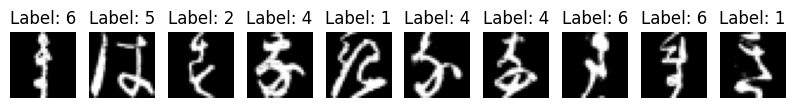

In [5]:
# Visualize some samples
print("Sample visualization from the training dataset:")
visualize_samples(train_dataset)

In [5]:

class VGGLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGLikeModel, self).__init__()
        self.features = nn.Sequential(  # nn.Sequential groups multiple layers together, allowing them to run in sequence
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # conv layer 1
            nn.ReLU(),   # ReLU activation introduces non-linearity
            nn.MaxPool2d(2, 2),  # max pooling - downsamples the image to reduce computation - reduces the image size by half
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # conv layer 2
            nn.ReLU(),   # ReLU activation introduces non-linearity
            nn.MaxPool2d(2, 2),  # max pooling
        )
        self.classifier = nn.Sequential(  # converts extracted features into class predictions
            nn.Linear(64 * 7 * 7, 256),  # fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),   # dropout layer
            nn.Linear(256, num_classes),  
        )

    def forward(self, x):
        x = self.features(x)   # extracts spatial patterns using convolution (extracts features)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  # converts extracted features into class probabilities
        return x  # returns raw logits (not probabilities), which will be passed to CrossEntropyLoss()

Training VGG-like model
Epoch 1/10, Train Loss: 0.2951, Val Loss: 0.0968, Val Accuracy: 0.9717
Epoch 2/10, Train Loss: 0.1002, Val Loss: 0.0664, Val Accuracy: 0.9792
Epoch 3/10, Train Loss: 0.0631, Val Loss: 0.0590, Val Accuracy: 0.9829
Epoch 4/10, Train Loss: 0.0477, Val Loss: 0.0531, Val Accuracy: 0.9835
Epoch 5/10, Train Loss: 0.0405, Val Loss: 0.0526, Val Accuracy: 0.9851
Epoch 6/10, Train Loss: 0.0279, Val Loss: 0.0539, Val Accuracy: 0.9849
Epoch 7/10, Train Loss: 0.0258, Val Loss: 0.0463, Val Accuracy: 0.9879
Epoch 8/10, Train Loss: 0.0221, Val Loss: 0.0522, Val Accuracy: 0.9874
Epoch 9/10, Train Loss: 0.0208, Val Loss: 0.0493, Val Accuracy: 0.9856
Epoch 10/10, Train Loss: 0.0175, Val Loss: 0.0487, Val Accuracy: 0.9876
Early stopping triggered! Stopping training.


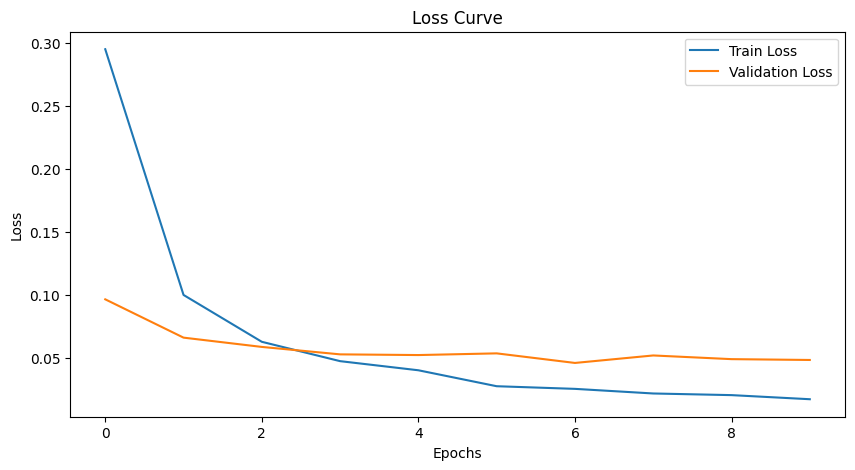

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      1000
           1       0.76      0.51      0.61      1000
           2       0.72      0.49      0.58      1000
           3       0.87      0.51      0.64      1000
           4       0.46      0.77      0.57      1000
           5       0.45      0.68      0.54      1000

    accuracy                           0.59      6000
   macro avg       0.65      0.59      0.59      6000
weighted avg       0.65      0.59      0.59      6000



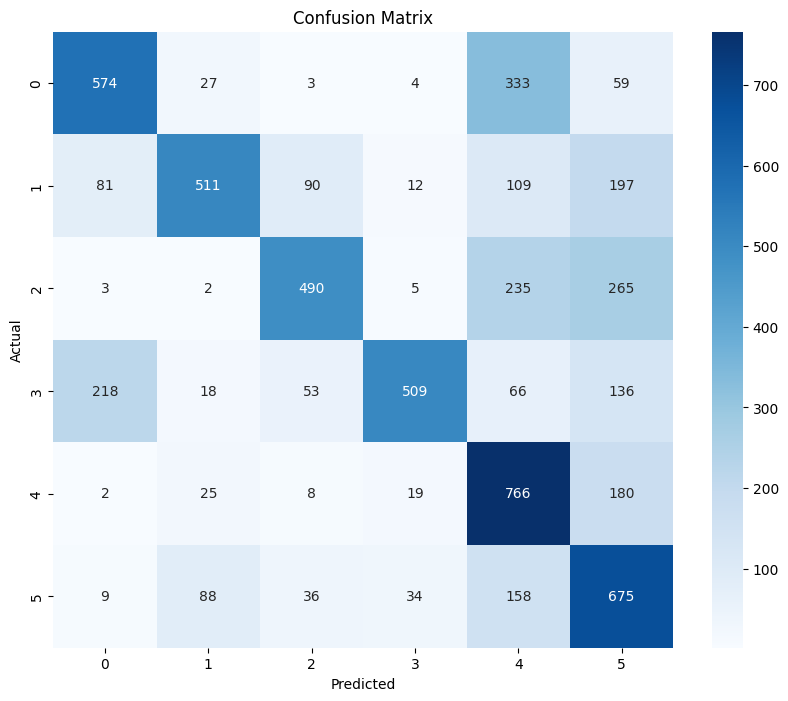

In [7]:
print("Training VGG-like model")
vgg_model = VGGLikeModel(num_classes)
vgg_model, val_accuracies = train_model(vgg_model, train_loader, val_loader)
evaluate_model(vgg_model, test_loader)

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResNetBlock, self).__init__()
        self.downsample = downsample
        # uses 3x3 convolution, If downsample=True, stride=2 reduces the spatial size (28x28 → 14x14), 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=(2 if downsample else 1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output channels are different, or downsampling is needed, the residual path includes:
        # 1x1 convolution (Conv2d) to match dimensions.
        # Batch Normalization (BatchNorm2d) for stability.
        # Otherwise, it keeps the input unchanged (Identity()).
        if downsample or in_channels != out_channels:
            self.residual_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual_connection = nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x) #store input for skip connection
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual     #  add skip connection
        x = nn.ReLU()(x)
        return x

class ResNetLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLikeModel, self).__init__()
        self.layer1 = ResNetBlock(1, 64, downsample=True)
        self.layer2 = ResNetBlock(64, 128, downsample=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))    # reduces feature map to 1x1
        self.fc = nn.Linear(128, num_classes)    # converts extracted features into class predictions

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x) 
        return x

Training ResNet-like model
Epoch 1/10, Train Loss: 0.3987, Val Loss: 0.2349, Val Accuracy: 0.9186
Epoch 2/10, Train Loss: 0.1252, Val Loss: 0.2386, Val Accuracy: 0.9126
Epoch 3/10, Train Loss: 0.0772, Val Loss: 0.1773, Val Accuracy: 0.9422
Epoch 4/10, Train Loss: 0.0554, Val Loss: 0.1375, Val Accuracy: 0.9553
Epoch 5/10, Train Loss: 0.0359, Val Loss: 0.1071, Val Accuracy: 0.9669
Epoch 6/10, Train Loss: 0.0293, Val Loss: 0.1150, Val Accuracy: 0.9646
Epoch 7/10, Train Loss: 0.0259, Val Loss: 0.0834, Val Accuracy: 0.9739
Epoch 8/10, Train Loss: 0.0171, Val Loss: 0.1076, Val Accuracy: 0.9672
Epoch 9/10, Train Loss: 0.0158, Val Loss: 0.0713, Val Accuracy: 0.9789
Epoch 10/10, Train Loss: 0.0159, Val Loss: 0.0935, Val Accuracy: 0.9708


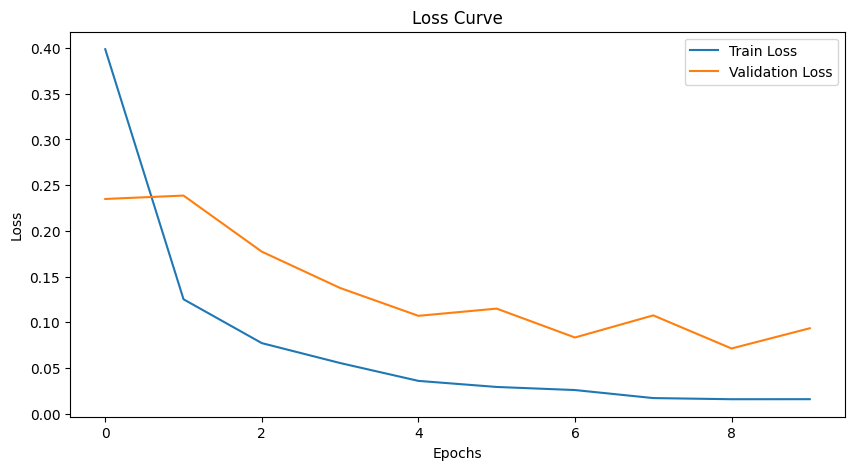

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.53      0.52      1000
           1       0.64      0.51      0.57      1000
           2       0.97      0.47      0.64      1000
           3       0.95      0.45      0.61      1000
           4       0.60      0.65      0.62      1000
           5       0.38      0.81      0.52      1000

    accuracy                           0.57      6000
   macro avg       0.68      0.57      0.58      6000
weighted avg       0.68      0.57      0.58      6000



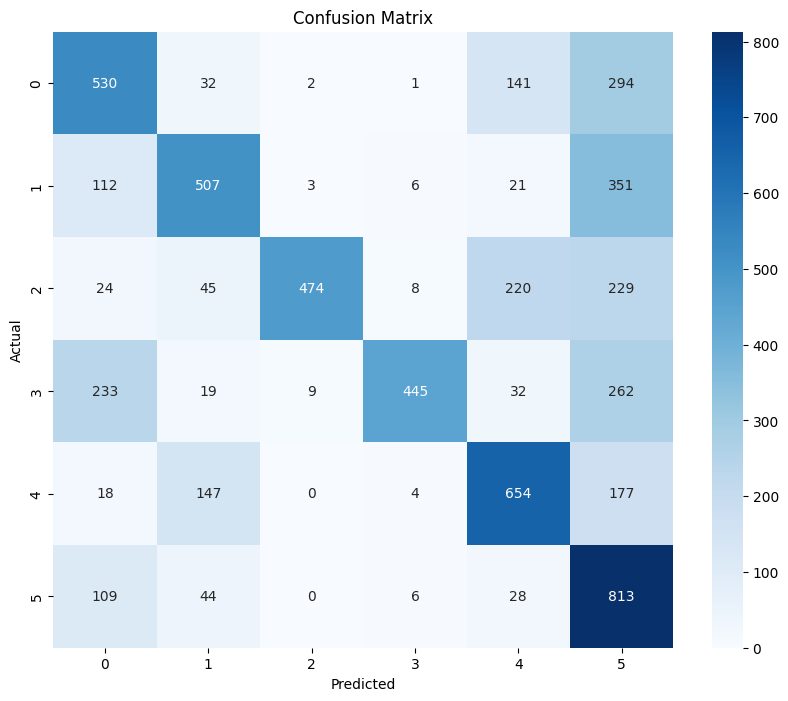

In [9]:
print("Training ResNet-like model")
resnet_model = ResNetLikeModel(num_classes)
resnet_model, val_accuracies = train_model(resnet_model, train_loader, val_loader)
evaluate_model(resnet_model, test_loader)

In [7]:
class EfficientNetLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetLikeModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),  # normalizes activations
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # flatten before fully connected layer
        x = self.classifier(x)
        return x

Training EfficientNet-like model
Epoch 1/10, Train Loss: 0.2873, Val Loss: 0.1127, Val Accuracy: 0.9660
Epoch 2/10, Train Loss: 0.1135, Val Loss: 0.0753, Val Accuracy: 0.9768
Epoch 3/10, Train Loss: 0.0812, Val Loss: 0.0743, Val Accuracy: 0.9768
Epoch 4/10, Train Loss: 0.0628, Val Loss: 0.0621, Val Accuracy: 0.9811
Epoch 5/10, Train Loss: 0.0507, Val Loss: 0.0507, Val Accuracy: 0.9867
Epoch 6/10, Train Loss: 0.0431, Val Loss: 0.0578, Val Accuracy: 0.9832
Epoch 7/10, Train Loss: 0.0392, Val Loss: 0.0523, Val Accuracy: 0.9844
Epoch 8/10, Train Loss: 0.0314, Val Loss: 0.0550, Val Accuracy: 0.9861
Early stopping triggered! Stopping training.


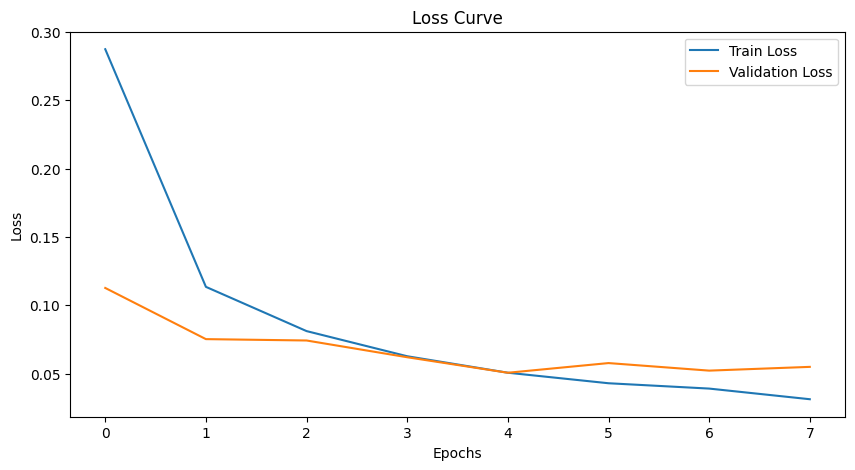

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.48      0.62      1000
           1       0.90      0.46      0.61      1000
           2       0.72      0.48      0.58      1000
           3       0.70      0.55      0.62      1000
           4       0.35      0.85      0.50      1000
           5       0.59      0.62      0.60      1000

    accuracy                           0.57      6000
   macro avg       0.69      0.57      0.59      6000
weighted avg       0.69      0.57      0.59      6000



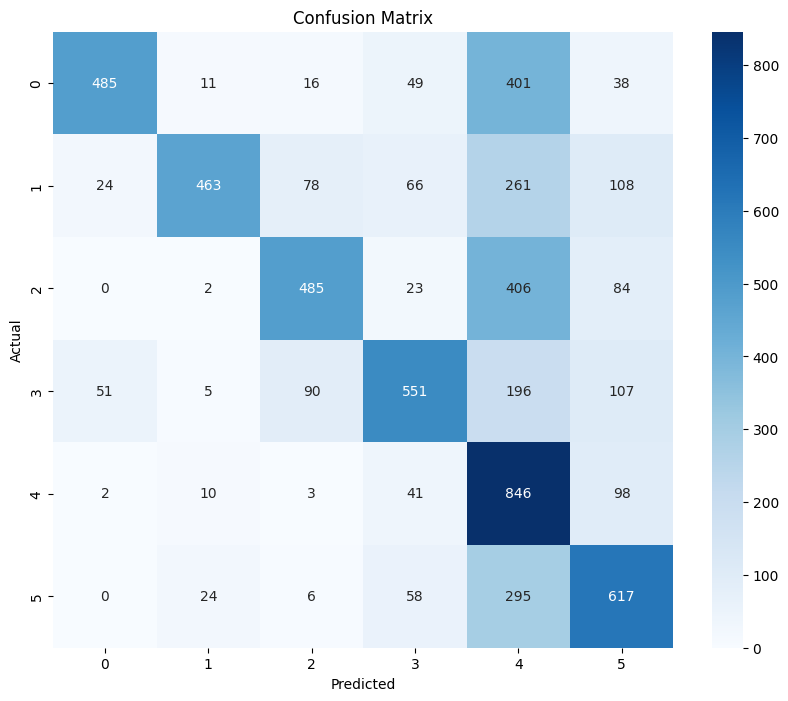

In [11]:

print("Training EfficientNet-like model")
efficientnet_model = EfficientNetLikeModel(num_classes)
efficientnet_model, val_accuracies = train_model(efficientnet_model, train_loader, val_loader)
evaluate_model(efficientnet_model, test_loader)

In [8]:
class VGGResNetHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGResNetHybridModel, self).__init__()
        
        # VGG-like feature extraction
        self.vgg_features = nn.Sequential(  # extracts low-level image features
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # resNet-like residual blocks - enables deeper feature extraction while preventing vanishing gradients
        self.res_block1 = ResNetBlock(64, 128, downsample=True)
        self.res_block2 = ResNetBlock(128, 256, downsample=True)
        
        # placeholder for input features to the classifier
        self.flattened_size = None
        
        # fully connected layers
        self.classifier = None
        self.num_classes = num_classes

    def forward(self, x):
        x = self.vgg_features(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        # dynamically calculate flattened size - flexibility in handling different input sizes
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.classifier = nn.Sequential(
                nn.Linear(self.flattened_size, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, self.num_classes),
            ).to(x.device)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


VGG and ResNet Hybrid model
Epoch 1/10, Train Loss: 0.1994, Val Loss: 0.0815, Val Accuracy: 0.9760
Epoch 2/10, Train Loss: 0.0581, Val Loss: 0.0817, Val Accuracy: 0.9735
Epoch 3/10, Train Loss: 0.0347, Val Loss: 0.0427, Val Accuracy: 0.9864
Epoch 4/10, Train Loss: 0.0191, Val Loss: 0.0339, Val Accuracy: 0.9897
Epoch 5/10, Train Loss: 0.0137, Val Loss: 0.0411, Val Accuracy: 0.9881
Epoch 6/10, Train Loss: 0.0127, Val Loss: 0.0561, Val Accuracy: 0.9835
Epoch 7/10, Train Loss: 0.0109, Val Loss: 0.0480, Val Accuracy: 0.9861
Early stopping triggered! Stopping training.


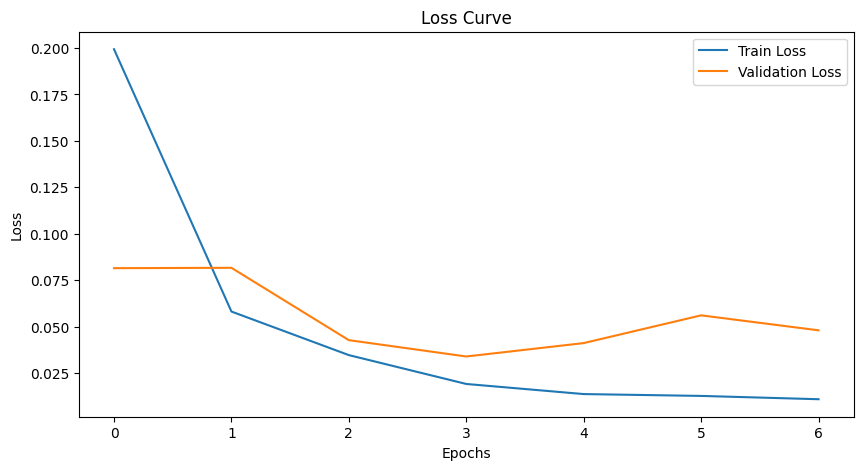

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.75      0.63      1000
           1       0.83      0.47      0.60      1000
           2       0.87      0.50      0.63      1000
           3       0.42      0.52      0.47      1000
           4       0.50      0.52      0.51      1000
           5       0.55      0.66      0.60      1000

    accuracy                           0.57      6000
   macro avg       0.62      0.57      0.57      6000
weighted avg       0.62      0.57      0.57      6000



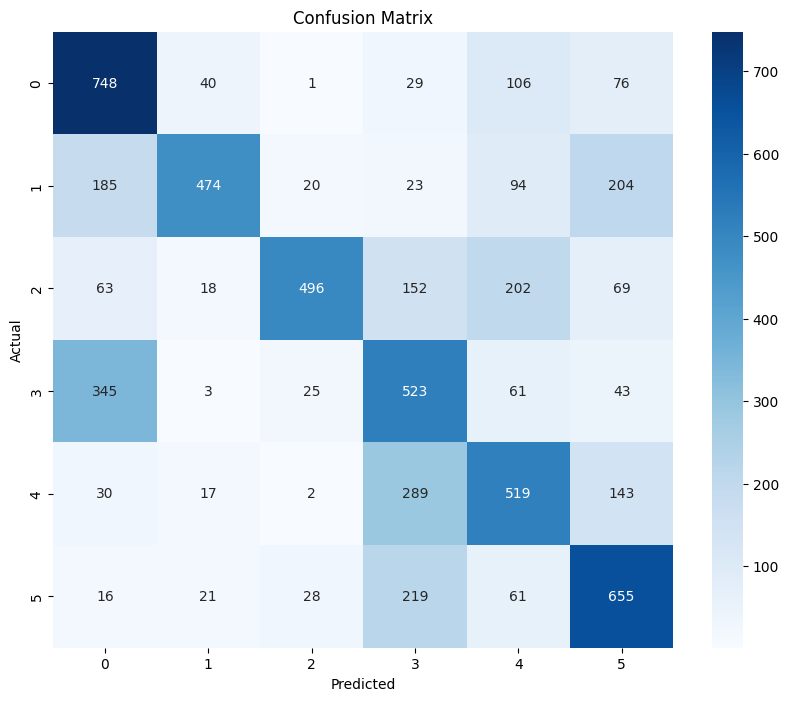

In [13]:
print("VGG and ResNet Hybrid model")
hybrid_model = VGGResNetHybridModel(num_classes)
hybrid_model, val_accuracies = train_model(hybrid_model, train_loader, val_loader)
evaluate_model(hybrid_model, test_loader)

## Step 2.
We have bad accuracy as expexed (57% in average). What can we do:
1. Create new train dataset consists of initial train dataset and initial train dataset with reversed color (TRAIN2 dataset).
2. Train model again using new train dataset.
3. Try different hyperparameters and normalization.

In [9]:
train2_dir = os.path.join(root_dir, "TRAIN2")

# Create TRAIN2 directory if it doesn't exist
if not os.path.exists(train2_dir):
    os.makedirs(train2_dir)

# Process each class folder (1-6)
for label in range(1, 7):
    class_dir = os.path.join(train_dir, str(label))
    new_class_dir = os.path.join(train2_dir, str(label))
    
    # Create class folder in TRAIN2 if it doesn't exist
    if not os.path.exists(new_class_dir):
        os.makedirs(new_class_dir)
    
    # Get all .npy files in the class folder
    file_names = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    
    for file_name in file_names:
        file_path = os.path.join(class_dir, file_name)
        new_file_path = os.path.join(new_class_dir, file_name)
        
        # Copy the original file
        shutil.copy(file_path, new_file_path)
        
        # Load image and invert pixels
        image = np.load(file_path)
        inverted_image = 1.0 - image  # Invert pixel values (assuming range [0,1])
        
        # Save inverted image with modified filename
        inverted_file_name = file_name.replace(".npy", "_inverted.npy")
        inverted_file_path = os.path.join(new_class_dir, inverted_file_name)
        np.save(inverted_file_path, inverted_image)

print("TRAIN2 dataset created successfully with original and inverted images.")

TRAIN2 dataset created successfully with original and inverted images.


In [10]:
class NewSymbolDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.data = []
        self.labels = []

        for label in range(1, 7):  # Classes 1 to 6
            class_dir = os.path.join(self.root_dir, self.split, str(label))
            file_names = sorted([f for f in os.listdir(class_dir) if f.endswith('.npy')])  # Sort to maintain order
            
            for file_name in file_names:
                file_path = os.path.join(class_dir, file_name)
                self.data.append(file_path)
                self.labels.append(label - 1)  # Maintain the same label for original & inverted images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.load(self.data[idx])  # Load .npy image
        label = self.labels[idx]

        # Ensure the image tensor has the correct shape (1, 28, 28)
        image = torch.tensor(image, dtype=torch.float32)
        if image.ndim == 2:  # If the image has no channel dimension
            image = image.unsqueeze(0)  # Add channel dimension to get (1, 28, 28)

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label


In [11]:
# Prepare datasets
train2_dataset = NewSymbolDataset(root_dir, "TRAIN2", transform=transform)

train2_size = int(0.8 * len(train2_dataset))
val2_size = len(train2_dataset) - train2_size
train2_subset, val2_subset = random_split(train2_dataset, [train2_size, val2_size])

# Dataloaders
train2_loader = DataLoader(train2_subset, batch_size=64, shuffle=True)
val2_loader = DataLoader(val2_subset, batch_size=64, shuffle=False)

Sample visualization from the training2 dataset:


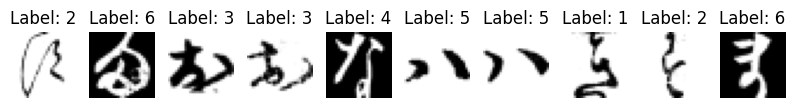

In [17]:
print("Sample visualization from the training2 dataset:")
visualize_samples(train2_dataset)

Training VGG-like model with combined train dataset
Epoch 1/10, Train Loss: 0.2999, Val Loss: 0.0949, Val Accuracy: 0.9694
Epoch 2/10, Train Loss: 0.1046, Val Loss: 0.0664, Val Accuracy: 0.9772
Epoch 3/10, Train Loss: 0.0741, Val Loss: 0.0507, Val Accuracy: 0.9847
Epoch 4/10, Train Loss: 0.0552, Val Loss: 0.0527, Val Accuracy: 0.9837
Epoch 5/10, Train Loss: 0.0474, Val Loss: 0.0530, Val Accuracy: 0.9855
Epoch 6/10, Train Loss: 0.0391, Val Loss: 0.0485, Val Accuracy: 0.9856
Epoch 7/10, Train Loss: 0.0354, Val Loss: 0.0497, Val Accuracy: 0.9856
Epoch 8/10, Train Loss: 0.0304, Val Loss: 0.0470, Val Accuracy: 0.9855
Epoch 9/10, Train Loss: 0.0267, Val Loss: 0.0448, Val Accuracy: 0.9883
Epoch 10/10, Train Loss: 0.0250, Val Loss: 0.0436, Val Accuracy: 0.9878


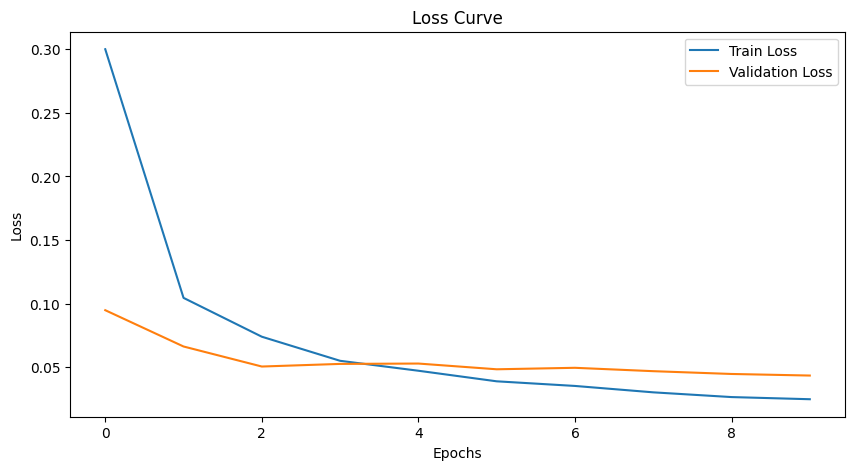

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      1000
           1       0.50      0.52      0.51      1000
           2       0.73      0.48      0.58      1000
           3       0.73      0.49      0.59      1000
           4       0.41      0.65      0.50      1000
           5       0.40      0.51      0.45      1000

    accuracy                           0.53      6000
   macro avg       0.58      0.53      0.54      6000
weighted avg       0.58      0.53      0.54      6000



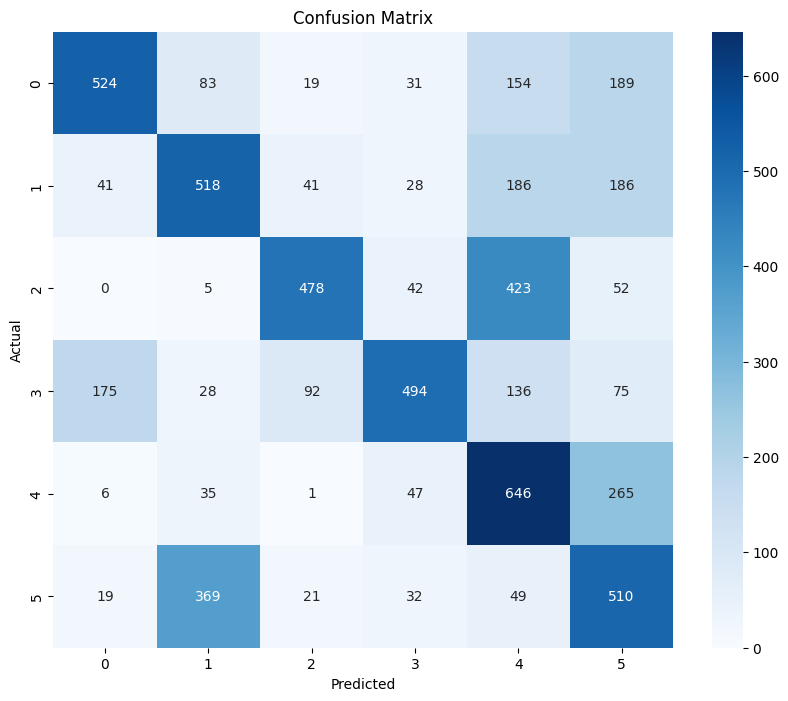

In [12]:
print("Training VGG-like model with combined train dataset")
vgg_model2 = VGGLikeModel(num_classes)
vgg_model2, val_accuracies2 = train_model(vgg_model2, train2_loader, val2_loader)
evaluate_model(vgg_model2, test_loader)

Training ResNet-like model with combined train dataset
Epoch 1/10, Train Loss: 0.4021, Val Loss: 0.2566, Val Accuracy: 0.9100
Epoch 2/10, Train Loss: 0.1237, Val Loss: 0.1295, Val Accuracy: 0.9591
Epoch 3/10, Train Loss: 0.0777, Val Loss: 0.0860, Val Accuracy: 0.9722
Epoch 4/10, Train Loss: 0.0556, Val Loss: 0.0618, Val Accuracy: 0.9799
Epoch 5/10, Train Loss: 0.0419, Val Loss: 0.1289, Val Accuracy: 0.9597
Epoch 6/10, Train Loss: 0.0315, Val Loss: 0.0848, Val Accuracy: 0.9724
Epoch 7/10, Train Loss: 0.0260, Val Loss: 0.0926, Val Accuracy: 0.9711
Early stopping triggered! Stopping training.


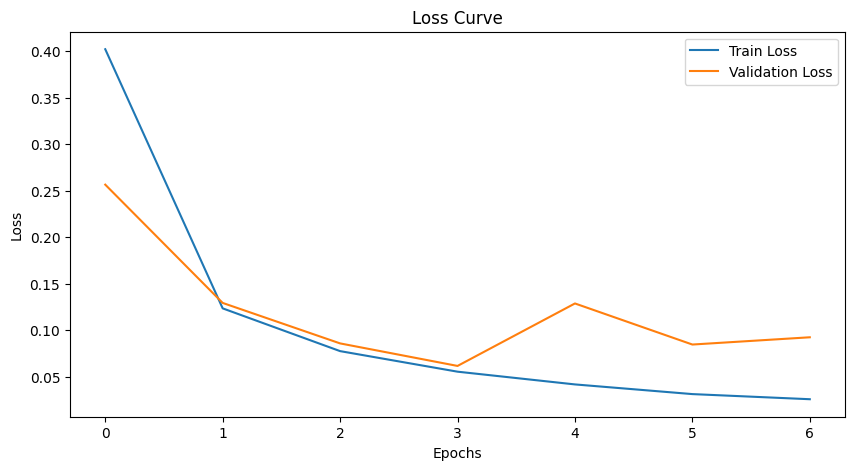

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.44      0.61      1000
           1       0.48      0.54      0.51      1000
           2       0.92      0.47      0.62      1000
           3       0.79      0.47      0.59      1000
           4       0.35      0.87      0.50      1000
           5       0.58      0.50      0.54      1000

    accuracy                           0.55      6000
   macro avg       0.69      0.55      0.56      6000
weighted avg       0.69      0.55      0.56      6000



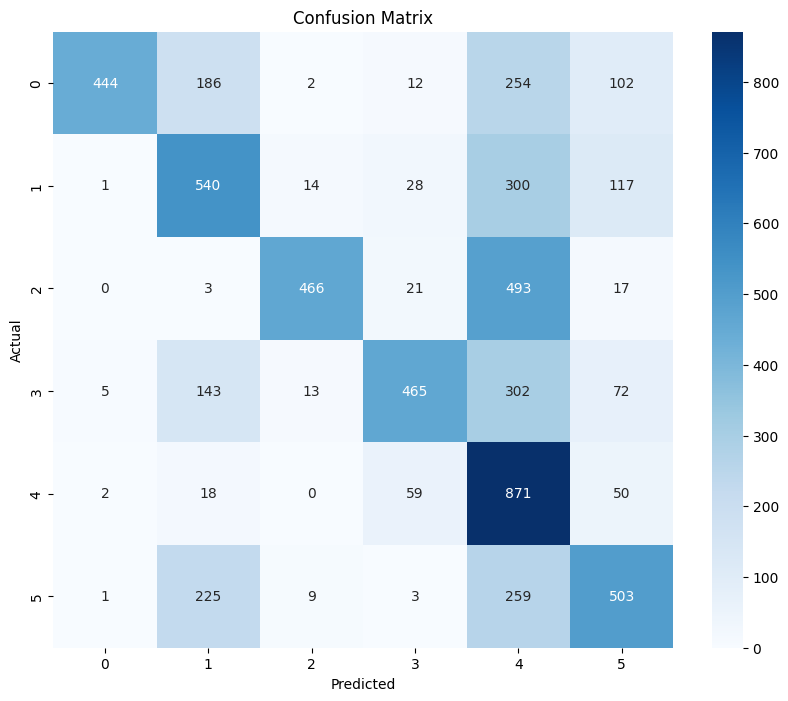

In [13]:
print("Training ResNet-like model with combined train dataset")
resnet_model2 = ResNetLikeModel(num_classes)
resnet_model2, val_accuracies2 = train_model(resnet_model2, train2_loader, val2_loader)
evaluate_model(resnet_model2, test_loader)

Training EfficientNet-like model with combined train dataset
Epoch 1/10, Train Loss: 0.2463, Val Loss: 0.0808, Val Accuracy: 0.9747
Epoch 2/10, Train Loss: 0.0994, Val Loss: 0.0668, Val Accuracy: 0.9796
Epoch 3/10, Train Loss: 0.0743, Val Loss: 0.0549, Val Accuracy: 0.9838
Epoch 4/10, Train Loss: 0.0591, Val Loss: 0.0479, Val Accuracy: 0.9840
Epoch 5/10, Train Loss: 0.0448, Val Loss: 0.0448, Val Accuracy: 0.9856
Epoch 6/10, Train Loss: 0.0406, Val Loss: 0.0380, Val Accuracy: 0.9892
Epoch 7/10, Train Loss: 0.0356, Val Loss: 0.0401, Val Accuracy: 0.9875
Epoch 8/10, Train Loss: 0.0323, Val Loss: 0.0375, Val Accuracy: 0.9882
Epoch 9/10, Train Loss: 0.0271, Val Loss: 0.0292, Val Accuracy: 0.9906
Epoch 10/10, Train Loss: 0.0210, Val Loss: 0.0348, Val Accuracy: 0.9901


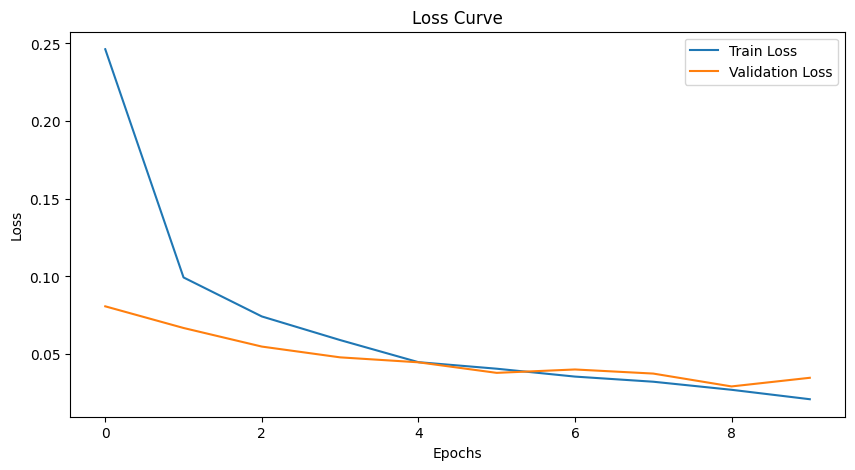

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.63      1000
           1       0.48      0.57      0.53      1000
           2       0.67      0.49      0.57      1000
           3       0.87      0.47      0.61      1000
           4       0.41      0.73      0.52      1000
           5       0.43      0.50      0.47      1000

    accuracy                           0.54      6000
   macro avg       0.62      0.54      0.55      6000
weighted avg       0.62      0.54      0.55      6000



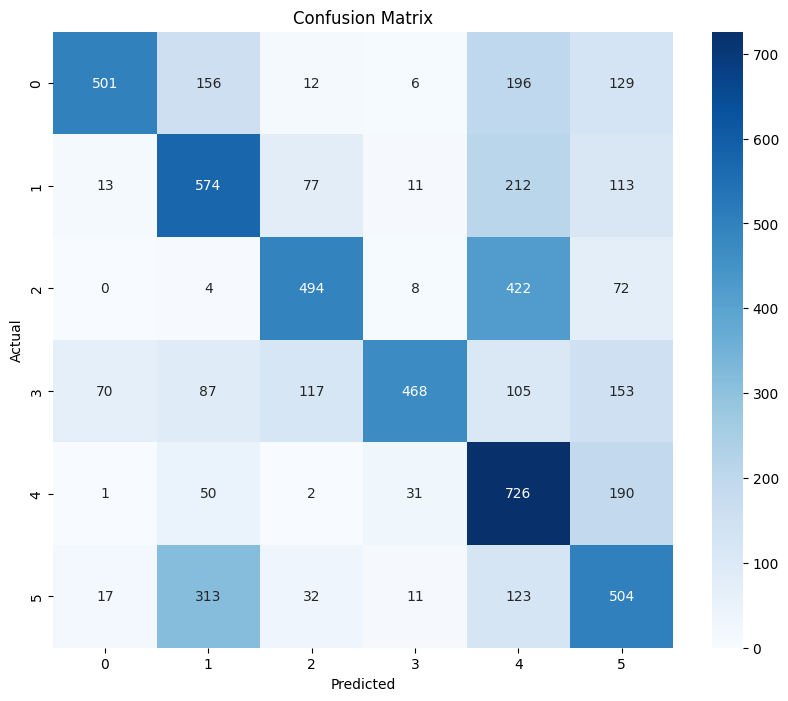

In [14]:

print("Training EfficientNet-like model with combined train dataset")
efficientnet_model2 = EfficientNetLikeModel(num_classes)
efficientnet_model2, val_accuracies2 = train_model(efficientnet_model2, train2_loader, val2_loader)
evaluate_model(efficientnet_model2, test_loader)

VGG and ResNet Hybrid model with combined train dataset
Epoch 1/10, Train Loss: 0.1717, Val Loss: 0.0605, Val Accuracy: 0.9816
Epoch 2/10, Train Loss: 0.0441, Val Loss: 0.0575, Val Accuracy: 0.9828
Epoch 3/10, Train Loss: 0.0242, Val Loss: 0.0403, Val Accuracy: 0.9867
Epoch 4/10, Train Loss: 0.0162, Val Loss: 0.0235, Val Accuracy: 0.9924
Epoch 5/10, Train Loss: 0.0110, Val Loss: 0.0224, Val Accuracy: 0.9922
Epoch 6/10, Train Loss: 0.0101, Val Loss: 0.0295, Val Accuracy: 0.9909
Epoch 7/10, Train Loss: 0.0074, Val Loss: 0.0189, Val Accuracy: 0.9948
Epoch 8/10, Train Loss: 0.0075, Val Loss: 0.0206, Val Accuracy: 0.9942
Epoch 9/10, Train Loss: 0.0057, Val Loss: 0.0144, Val Accuracy: 0.9962
Epoch 10/10, Train Loss: 0.0051, Val Loss: 0.0163, Val Accuracy: 0.9953


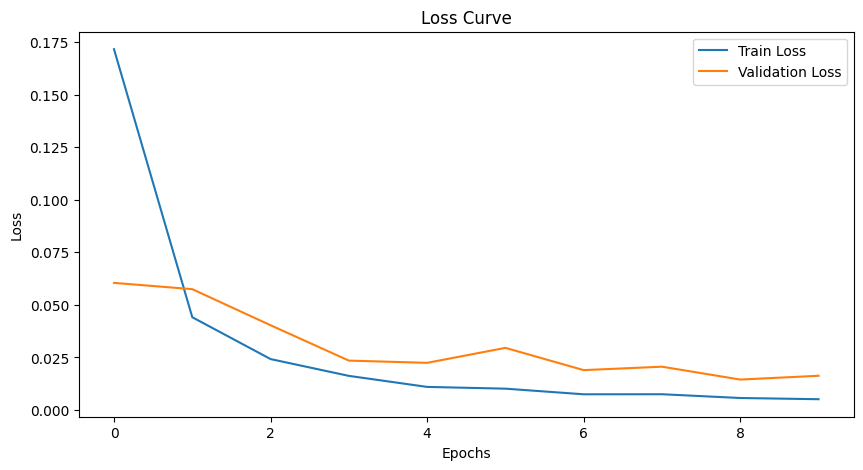

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.54      0.61      1000
           1       0.49      0.63      0.55      1000
           2       0.96      0.48      0.64      1000
           3       0.74      0.49      0.59      1000
           4       0.39      0.77      0.52      1000
           5       0.57      0.49      0.53      1000

    accuracy                           0.57      6000
   macro avg       0.65      0.57      0.57      6000
weighted avg       0.65      0.57      0.57      6000



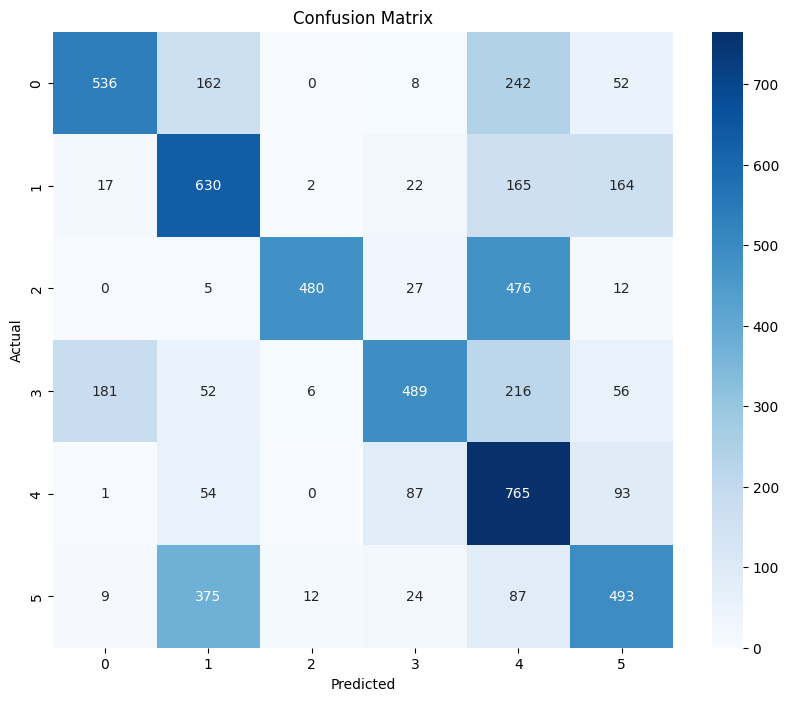

In [15]:
print("VGG and ResNet Hybrid model with combined train dataset")
hybrid_model2 = VGGResNetHybridModel(num_classes)
hybrid_model2, val_accuracies2 = train_model(hybrid_model2, train2_loader, val2_loader)
evaluate_model(hybrid_model2, test_loader)

Using new TRAIN2 dataset I got worse result (55% in average). That means that TEST dataset has one more type of symbols which is not in train dataset.

I tried differnt normalization, such transforms.RandomRotation(10), transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), but the best accuracy in both steps I got only using transforms.Normalize((0.5,), (0.5,));

Also tried increase the number of filters (64 instead of 32), but got quite the same result, so I left 32 as was initially